## **Fraud detection**

**Anomaly detection in credit cards transactions (frauds) using unsupervised deep learning model - Autoencoder.**

The aim of this project is predict whether a given transaction was a fraud or not. In this case we will apply anomaly detection with Autoencoder - unsupervised deep learning model. For our analysis we will use the Python, mostly Tensorflow Keras library to illustrate the process of identifying outliers using an autoencoder. 

**Dataset:**

The dataset used for credit cards fraud detection is derived from Kaggle.

It contains transactions made by credit cards in two days in 2013 by European cardholders. There are 492 frauds out of 284,807 transactions. 

### **Import libriaries and data**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**First observations:**

In [ ]:
df.shape

(284807, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Checking missing values:

In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

The dataset consists only numerical values and majority features (V1 to V28) are the result of ‘Principal Component Analysis (PCA)’ transformation. The ‘Time’ and ‘Amount’ features are not transformed data. There are no missing values in the dataset.

### **Data preparation**

**Data normalization**

The majority of our data are normalized (V1 to V28 values) which are result of PCA analysis. We also have to normalized rest of the data (Time and Amount) so that their high values do not adversely affect the training of the model.

In [ ]:
df_sc = df.copy()

In [ ]:
df_sc['Time'] = StandardScaler().fit_transform(df_sc['Time'].values.reshape(-1, 1))
df_sc['Amount'] = StandardScaler().fit_transform(df_sc['Amount'].values.reshape(-1, 1))

**Splitting dataset into train and test data**

We prepare our data assumming that frauds are anomalies in our transactions. To better build anomaly detection model we create train data with only normal transactions without fraud. The frauds go into test data only.


In [ ]:
train, test = train_test_split(df_sc, test_size=0.3, random_state = 10)

In [ ]:
X_train = train[train['Class'] == 0]
X_train = X_train.drop(['Class'], axis=1)
 
X_test = test.drop(['Class'], axis=1)
y_test = test['Class'] 

In [ ]:
print(f'X_train shape: {X_train.shape};')
print(f'X_test shape: {X_test.shape}; y_test shape: {y_test.shape}')

X_train shape: (199013, 30);
X_test shape: (85443, 30); y_test shape: (85443,)


### **Build model**

We build autoencoder model for anomaly detection.

The Autoencoder is a neural network which learns to copy its inputs to outputs, i.e. it learn the compressed representation of raw data. It is based on unsupervised machine learning that applies the backpropagation technique and sets the target values equal to the inputs. Autoencoder contains two parts named encoder and decoder. The encoder compresses the input into a latent space representation while the decoder decodes the encoded image back to the original image of the same dimension. 

In our case we used the architecture for deep autoencoders, we reduce the amount of input data to a smaller representation of neurons. 
We create the input layer, encoder layers and decoder layers. In the input layer, we specifie the shape of the dataset (dataset has 30 features so the shape is 30). First three layers are used for our encoder and consists of layers with 16, 8, and 4 neurons, respectively. The last three layers are the decoder consisting of layers with 8, 16, and 30 neurons, respectively. Additionally, L1 regularization will be used during training.
After defining the input, encoder and decoder layers, we create the autoencoder model to combine the layers.

In [ ]:
learning_rate = 0.00001
input_dim = X_train.shape[1]
 
input_layer = Input(shape=(input_dim, ))

encoder = Dense(16, activation='elu', activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(8, activation='relu')(encoder)
encoder = Dense(4, activation='relu')(encoder)

decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(16, activation='relu')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)
 
autoencoder = Model(inputs=input_layer, outputs=decoder)


We compile the model with the optimizer of adam and the loss of mse (Mean Squared Error). We also define an early stopping method to avoid training longer than needed.

In [ ]:
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

 
EarlyStop = EarlyStopping(monitor='accuracy', patience=5, verbose=1)
 
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 30)                510   

We train the model for 20 epoch:

In [ ]:
history = autoencoder.fit(X_train, X_train, 
          epochs=20,
          batch_size = 64,
          validation_data = (X_test, X_test),
          callbacks = EarlyStop,
          shuffle=True)

Epoch 1/20
3110/3110 [==============================] - 11s 3ms/step - loss: 0.7114 - accuracy: 0.4716 - val_loss: 0.6838 - val_accuracy: 0.5588
Epoch 2/20
3110/3110 [==============================] - 10s 3ms/step - loss: 0.6214 - accuracy: 0.5681 - val_loss: 0.6484 - val_accuracy: 0.5728
Epoch 3/20
3110/3110 [==============================] - 9s 3ms/step - loss: 0.5987 - accuracy: 0.5731 - val_loss: 0.6351 - val_accuracy: 0.5747
Epoch 4/20
3110/3110 [==============================] - 8s 3ms/step - loss: 0.5880 - accuracy: 0.5752 - val_loss: 0.6248 - val_accuracy: 0.5780
Epoch 5/20
3110/3110 [==============================] - 8s 3ms/step - loss: 0.5795 - accuracy: 0.5809 - val_loss: 0.6171 - val_accuracy: 0.5836
Epoch 6/20
3110/3110 [==============================] - 10s 3ms/step - loss: 0.5732 - accuracy: 0.5832 - val_loss: 0.6120 - val_accuracy: 0.5819
Epoch 7/20
3110/3110 [==============================] - 9s 3ms/step - loss: 0.5670 - accuracy: 0.5842 - val_loss: 0.6051 - val_accura

Visualization of training:

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

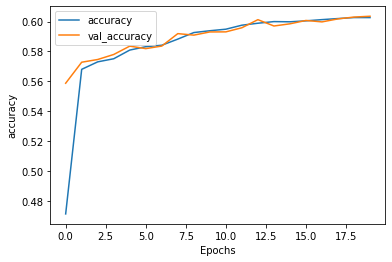

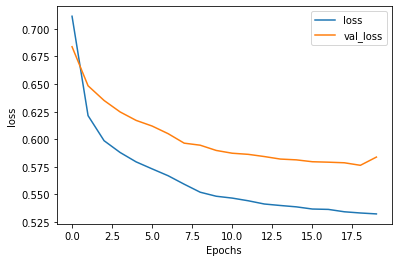

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


This charts show the training and validation loss and accuracy changes during the model fitting. We can see that both training and validation losses decrease with the increase of epochs.

### **Model evaluation**

In this step we use our model to predict the outliers. We use `predict` method to  get the reconstruction value for the testing data set containing the usual data points and the outliers.

In [ ]:
prediction = autoencoder.predict(X_test)

Now we look at the error distribution:

In [ ]:
mse = np.mean(np.power(X_test - prediction, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'class': y_test})

In [ ]:
error_df.describe()

,reconstruction_error,class
count,85443.000000,85443.00000
mean,0.583696,0.00165
std,3.052918,0.04059
min,0.046345,0.00000
25%,0.177264,0.00000
50%,0.282487,0.00000
75%,0.465414,0.00000
max,277.353120,1.00000


Reconstruction error histogram on test sample:

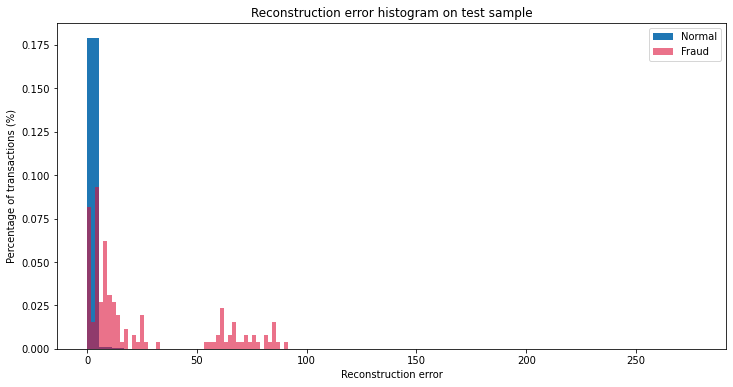

In [ ]:
bins = 50
plt.figure(figsize=(12, 6))
plt.hist(error_df[error_df['class'] == 0]['reconstruction_error'], bins, alpha=1, density=True, label='Normal')
plt.hist(error_df[error_df['class'] == 1]['reconstruction_error'], bins, alpha=0.6, density=True, label='Fraud', color='crimson')
plt.legend(loc='upper right')
plt.title("Reconstruction error histogram on test sample")
plt.xlabel("Reconstruction error")
plt.ylabel("Percentage of transactions (%)");
plt.show()

From chart above we can see that most of the transactions with a high spread are actually frauds.


**Reconstruction Error vs Threshold Check**

In order to predict whether or not a new/unseen transaction is normal or fraud, we’ll calculate the reconstruction error from the transaction data itself. We define a threshold based on which
we will predicted normal data points. If the error is larger than a  threshold, we’ll mark it as a fraud (since our model should have a low error on normal transactions). In our case the threshold is 3.

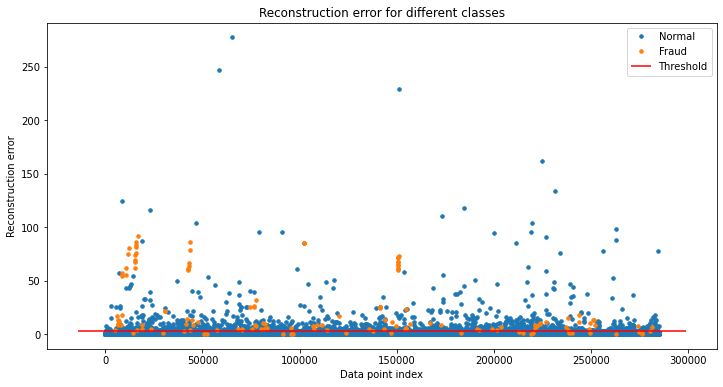

In [ ]:
threshold=3

groups = error_df.groupby('class')
fig, ax = plt.subplots(figsize=(12, 6))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

We see that our model  seems to catch a lot of the fraud cases. We can also increase or decrease the value of the threshold, depending on the problem.


We also check the prediction performance:

In [ ]:
threshold_prediction = [0 if i < threshold else 1 for i in mse]

print(classification_report(y_test, threshold_prediction))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85302
           1       0.08      0.83      0.14       141

    accuracy                           0.98     85443
   macro avg       0.54      0.91      0.57     85443
weighted avg       1.00      0.98      0.99     85443



The recall value of 0.83 shows that around 83% of the outliers were captured by the autoencoder.

**Confusion Matrix**

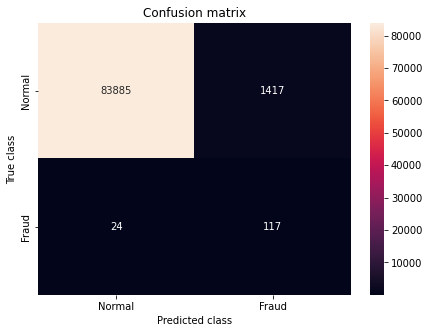

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df['class'], y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, xticklabels=['Normal','Fraud'], 
            yticklabels=['Normal','Fraud'],
            annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Looking at the confusion matrix we see pretty low False Negative rate and 117 frauds correctly classified by the model. Only stayed 24 of fraud transactions not correctly classified by the model.

### **Summary**



This project was aimed to fraud detection in credit cards transactions. In this part we used  autoencoders to fraud anomaly detection. We built the model only on one-class examples (normal transactions) with no suspicious transactions. The architecture which we have used for deep autoencoders it seems to be good and catching fraud transactions.  We evaluated our model with a few methods such as reconstruction error,  recall and confusion matrix. Our model  captures 83% of the anomaly data points (based on recall value) and  has the low False Negatives rate and will be not miss many anomalies. 